In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Importing Data

In [2]:
train = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/Train.csv')
test = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/Test.csv')
sample = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/SampleSubmission.csv')

In [3]:
# sample = pd.read_csv('/kaggle/input/deepflow/SampleSubmission.csv') 
# test = pd.read_csv('/kaggle/input/deepflow/Test.csv')
# train = pd.read_csv('/kaggle/input/deepflow/Train.csv')

### Importing Data

In [4]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.linear_model import LinearRegression
plt.style.use("ggplot")
import catboost as cb 



### Visiualization

In [5]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for', fontsize=15)
    plt.show()

c:\Users\tun20\.conda\envs\dlia\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  


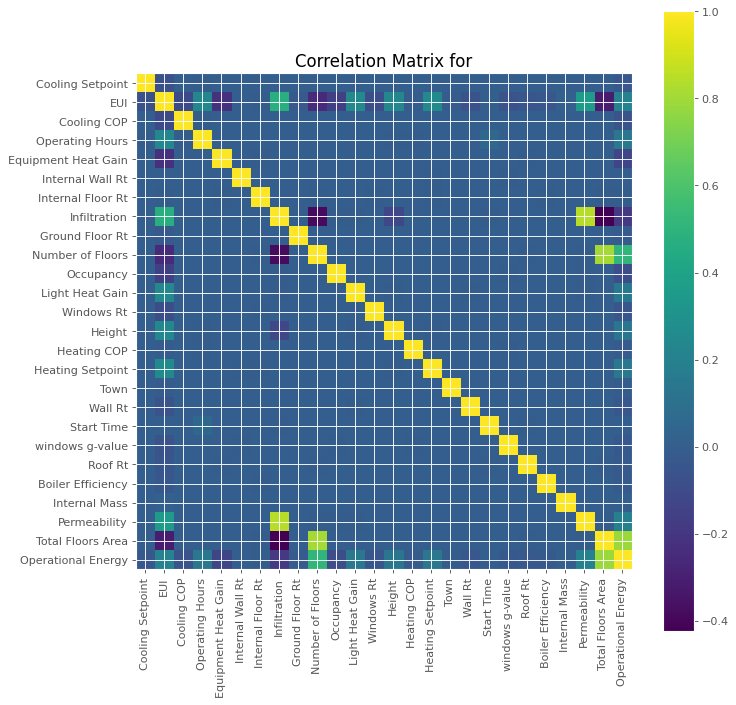

In [6]:
plotCorrelationMatrix(train, 10)

c:\Users\tun20\.conda\envs\dlia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Operational Energy'>

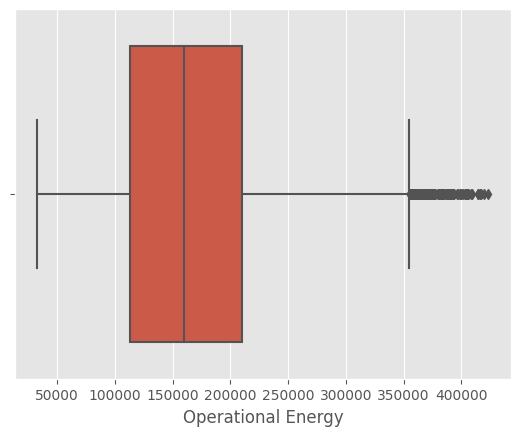

In [7]:
sns.boxplot(train['Operational Energy'])

c:\Users\tun20\.conda\envs\dlia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='EUI'>

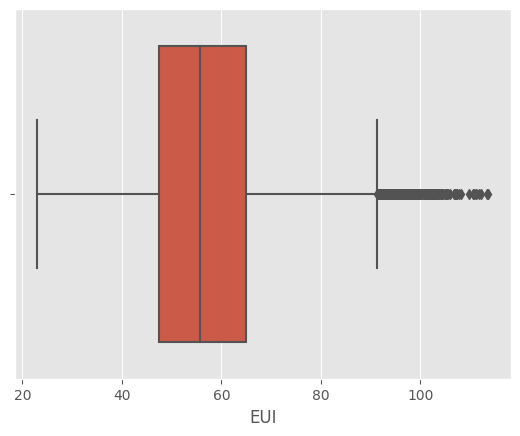

In [8]:
sns.boxplot(train['EUI'])

In [9]:
# calculate the correlation matrix
corr_matrix = train.corr()
# corr_matrix

<AxesSubplot:>

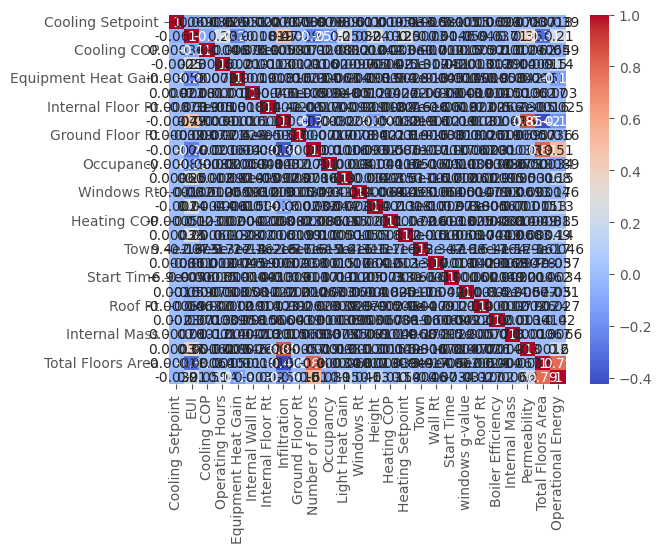

In [10]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


<AxesSubplot:>

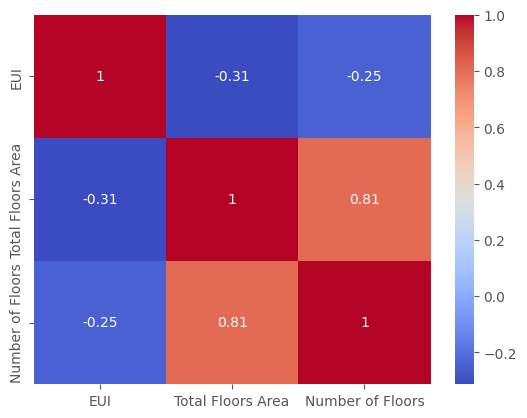

In [11]:
corr_matrix = train.loc[:, ['EUI', 'Total Floors Area', 'Number of Floors']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

<AxesSubplot:>

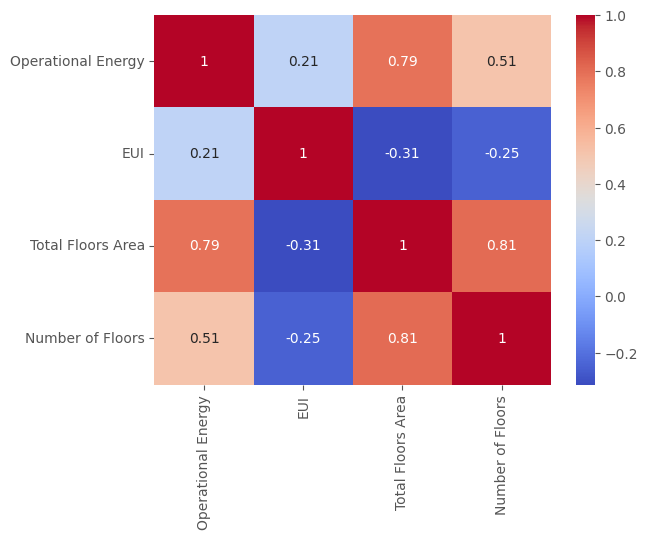

In [12]:
corr_matrix = train.loc[:, ['Operational Energy', 'EUI', 'Total Floors Area', 'Number of Floors']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### Preprocessing and feature engineering 

In [13]:
def prepross(data):
    wwr = []
    
    for x in data['WWR']: 
        test_map = x.replace('(' , '').replace(')' , '')
        tupe = tuple(map(float, test_map.split(',')))
        wwr.append(mean(tupe))
    data[['Cooling', 'Lights']] = data['random load mesures'].str.extract(r'Cooling\': \'(?P<Cooling>[0-9\.]+):C\', \'Lights\': \'(?P<Lights>[0-9\.]+):C')
    data['Cooling']=data['Cooling'].astype(float)
    data['Lights']=data['Lights'].astype(float)
    data.drop(columns=['random load mesures','building','File'], inplace= True)
    data['WWR'] = wwr
    return data 
    
def feature_engineer(data): 
    data['energy_unit'] = (data['EUI'] * data['Total Floors Area'] ) / data['Number of Floors']
    
    data['energy_unit'] = [np.round(num, 9) for num in data['energy_unit']]
    data = data.drop(['EUI', 'Total Floors Area','Number of Floors'], axis = 1 )
    
    return data

In [14]:
# rounded_vec = []
# x = train['Operational Energy']
# v =  (train['EUI'] * train['Total Floors Area'] ) / train['Number of Floors']

# for value in v:
#     rounded_vec = [np.round(num, 9a) for num in v]

In [15]:
train = prepross(train)
train = feature_engineer(train)
test = prepross(test)
test = feature_engineer(test)

### Training  

In [16]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as MSE
X = np.array(train['energy_unit'])
X = X.reshape(-1,1)
y = np.array(train['Operational Energy'])

In [17]:
reg = LinearRegression(fit_intercept=True ).fit(X, y)
y_pred =reg.predict(np.array(X).reshape(-1,1))

In [18]:
# RMSE Computation
rmse = np.sqrt(MSE(y, y_pred))
print("RMSE : % f" %(rmse))

RMSE :  0.000000


In [19]:
result = reg.predict(np.array(test['energy_unit']).reshape(-1,1)) 


### Exporting

In [20]:
# sample_clean = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/submission1 (2).csv')
# sample_clean['prediction_label']  = result
# sample_clean.to_csv('linear_regression.csv', index=False)

In [21]:
submission = pd.read_csv("C:/Users/tun20/Desktop/Hackathons/AI Hackflow/Test.csv")

In [22]:
submission['ID'] = submission.apply(lambda x: f"Building_{x['building'].split('_')[1]}_Town_{x['Town']}", axis=1)

In [23]:
submission.columns

Index(['building', 'File', 'Cooling Setpoint', 'EUI', 'Cooling COP',
       'Operating Hours', 'WWR', 'Equipment Heat Gain', 'Internal Wall Rt',
       'Internal Floor Rt', 'Infiltration', 'Ground Floor Rt',
       'Number of Floors', 'Occupancy', 'Light Heat Gain', 'Windows Rt',
       'Height', 'Heating COP', 'Heating Setpoint', 'Town', 'Wall Rt',
       'Start Time', 'windows g-value', 'Roof Rt', 'Boiler Efficiency',
       'Internal Mass', 'Permeability', 'Total Floors Area',
       'random load mesures', 'ID'],
      dtype='object')

In [24]:
submission.drop(columns={'building', 'File', 'Cooling Setpoint', 'EUI', 'Cooling COP',
       'Operating Hours', 'WWR', 'Equipment Heat Gain', 'Internal Wall Rt',
       'Internal Floor Rt', 'Infiltration', 'Ground Floor Rt',
       'Number of Floors', 'Occupancy', 'Light Heat Gain', 'Windows Rt',
       'Height', 'Heating COP', 'Heating Setpoint', 'Town', 'Wall Rt',
       'Start Time', 'windows g-value', 'Roof Rt', 'Boiler Efficiency',
       'Internal Mass', 'Permeability', 'Total Floors Area',
       'random load mesures'}, inplace= True)

In [25]:
submission['prediction'] = result

In [26]:
submission.head()

,ID,prediction
0,Building_1_Town_1,73062.463419
1,Building_100_Town_1,106643.525899
2,Building_1000_Town_2,88718.965742
3,Building_10000_Town_0,344952.564115
4,Building_10005_Town_2,240320.078745


In [27]:
submission.to_csv('submission.csv', index=False)